# Single-image food volume estimation
Using a  monocular depth estimation network and a segmentation model we will estimate the volume of the food displayed in the input image.

In [1]:
import sys
sys.path.append('../code')
sys.path.append('../code/depth_estimation')
sys.path.append('../code/segmentation/food')
import json
from keras.models import Model, model_from_json
from estimate_volume import VolumeEstimator
from custom_modules import *
from food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud

# Create estimator object and intialize
estimator = VolumeEstimator(arg_init=False)
with open('../trained_models/fine_tune_food_videos/monovideo_fine_tune_food_videos.json', 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False)
estimator.monovideo.load_weights(
    '../trained_models/fine_tune_food_videos/monovideo_fine_tune_food_videos.h5')
estimator.model_input_shape = estimator.monovideo.inputs[0].shape[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
print('[*] Loaded depth estimation model.')

# Depth model configuration
MIN_DEPTH = 0.01
MAX_DEPTH = 10
estimator.min_disp = 1 / MAX_DEPTH
estimator.max_disp = 1 / MIN_DEPTH
estimator.gt_depth_scale = 0.35 # Ground truth expected median depth

# Create segmentator object
estimator.segmentator = FoodSegmentator('../trained_models/segmentation/mask_rcnn_food_segmentation.h5')

# Set plate adjustment relaxation parameter
estimator.relax_param = 0.01

Using TensorFlow backend.


[*] VolumeEstimator not initialized.
Instructions for updating:
Colocations handled automatically by placer.


W1219 15:42:31.453708 140282489993024 deprecation.py:323] From /home/alex/virtualenvs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use the `axis` argument instead


W1219 15:42:37.414350 140282489993024 deprecation.py:506] From ../code/depth_estimation/project.py:199: calling squeeze (from tensorflow.python.ops.array_ops) with squeeze_dims is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


Instructions for updating:
Use tf.cast instead.


W1219 15:42:37.507256 140282489993024 deprecation.py:323] From ../code/depth_estimation/project.py:236: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


[*] Loaded depth estimation model.
[*] Loading segmentation model weights ../trained_models/segmentation/mask_rcnn_food_segmentation.h5


Using the outputs from the estimator we create and visualize the object and estimated plane point clouds.

[*] Creating intrinsics matrix from given FOV: 71
[*] Found 1 food object(s) in image.
[*] Concave food surface
[*] Estimated plane parameters (w0,w1,w2,w3): [0.32933300733566284, 0.1270405650138855, -0.43994635343551636, -1]
[*] Estimated volume: 0.11714676068343162 L


<IPython.core.display.Javascript object>


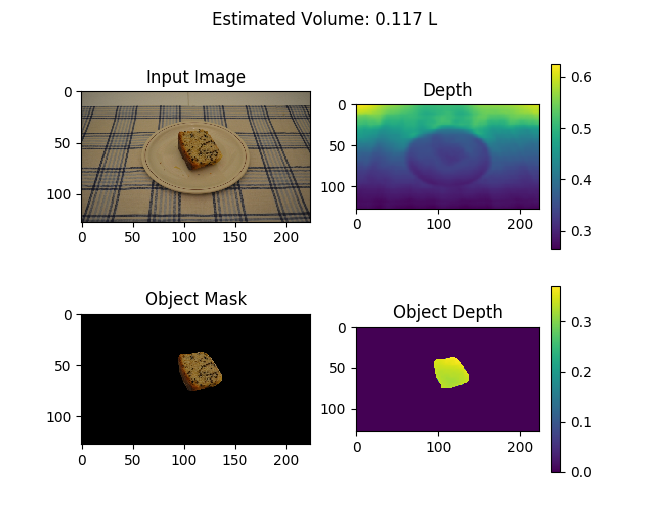

/home/alex/virtualenvs/tensorflow3/lib/python3.6/site-packages/pythreejs/traits.py:177: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.005720112405507013, 0.007423128857436966,…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.005548448732895896, 0.09790400925558265, …

<IPython.core.display.Javascript object>


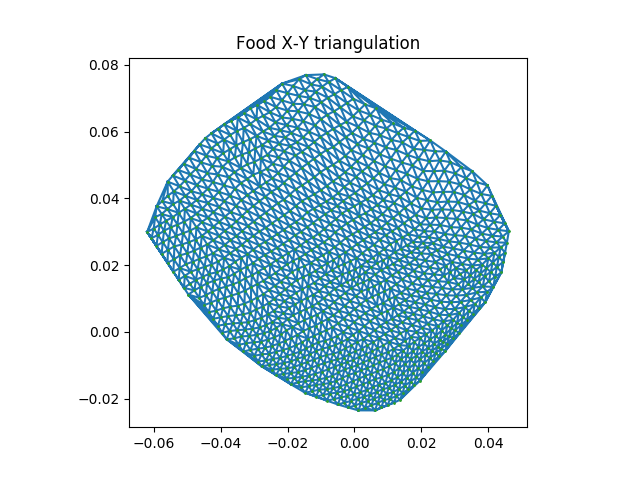

In [2]:
%matplotlib notebook
outputs_list = estimator.estimate_volume('../assets/volume_tests/food_measurements/cake_test_2.JPG',
                                         fov=71, focal_length=None, plot_results=True)

# Plot results for all detected food objects
for outputs in outputs_list:
    (estimated_volume, object_points_df, non_object_points_df, plane_points_df, object_points_transformed_df, 
        plane_points_transformed_df, simplices) = outputs
    fig = plt.gcf()
    fig.suptitle('Estimated Volume: {:.3f} L'.format(estimated_volume * 1000.0), fontsize=12)
    fig.set_size_inches(6.5, 5.3)

    # Flip x and z coordinates to match point cloud with plotting axes
    object_points_df.values[:,0] *= -1
    object_points_df.values[:,2] *= -1
    non_object_points_df.values[:,0] *= -1
    non_object_points_df.values[:,2] *= -1
    plane_points_df.values[:,0] *= -1
    plane_points_df.values[:,2] *= -1
    
    # Create point cloud objects and plot
    object_pc = PyntCloud(object_points_df)
    non_object_pc = PyntCloud(non_object_points_df)
    plane_pc = PyntCloud(plane_points_df)
    scene = object_pc.plot(initial_point_size=0.005, return_scene=True)
    non_object_pc.plot(initial_point_size=0.005, scene=scene)
    plane_pc.plot(initial_point_size=0.001, use_as_color='z', cmap='cool', scene=scene)
    
    # Create transformed point clouds and plot
    plane_transformed_pc = PyntCloud(plane_points_transformed_df)
    object_transformed_pc = PyntCloud(object_points_transformed_df)
    scene = object_transformed_pc.plot(initial_point_size=0.005, return_scene=True)
    plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

    # Plot x-y plane triangulation of food object
    volume_points = object_points_transformed_df.values[object_points_transformed_df.values[:,2] > 0]
    plt.figure()
    plt.triplot(volume_points[:,0], volume_points[:,1], simplices)
    plt.plot(volume_points[:,0], volume_points[:,1], 'o', markersize=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Food X-Y triangulation')

    plt.show()